## 循环神经网络

RNN(Recurrent Neural Network)

$$H_t = \phi(X_tW_{xh} + H_{t-1}W_{hh} + b_h)$$
$$O_t = H_tW_{hq} + b_q$$

**循环神经网络的隐藏状态可以捕捉至当前时间步的序列的历史信息**

**神经网络在不同时间步共享模型参数， 因此循环神经网络的模型参数的数量不随时间不的增长而增长**

<https://github.com/nicklashansen/rnn_lstm_from_scratch>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

## dataset

In [2]:
def load_dataset(size=None):
    
    trans = []
    if size :
        trans.append(transforms.Resize(size))

    trans.append(transforms.ToTensor())

    transform = torchvision.transforms.Compose(trans)

    mnist_train = torchvision.datasets.MNIST(root='../Datasets/MNIST', train=True, download=True,
                                                    transform=transform)
    mnist_test = torchvision.datasets.MNIST(root='../Datasets/MNIST', train=False, download=True,
                                                   transform=transform)
    return mnist_train, mnist_test

In [3]:
mnist_train, mnist_test = load_dataset(size=28)

In [4]:
print(len(mnist_train), len(mnist_test))

60000 10000


In [5]:
def get_mnist_labels(labels):
    text_labels = ['zero', 'one', 'two', 'three', 'four',
                   'five', 'six', 'seven', 'eight', 'nine']
    return [text_labels[int(i)] for i in labels]

In [6]:
def show_fashion_mnist(images, labels):
    display.set_matplotlib_formats('svg')
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

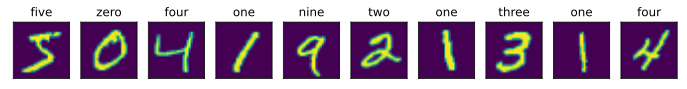

In [7]:
images, labels = [], []
for i in range(10):
    images.append(mnist_train[i][0])
    labels.append(mnist_train[i][1])
labels = get_mnist_labels(labels)


show_fashion_mnist(images, labels)

In [8]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)

        # Forward propagate LSTM
        out, _ = self.rnn(x, h_0)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

In [9]:
def test(model, test_loader, sequence_length, input_size, epoch, device):

    model.eval()
    with torch.no_grad():
        test_acc, num_samples = 0, 0

        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            pred_y = model(images)
            test_acc += (pred_y.argmax(dim=1) == labels).float().sum().cpu().item()
            num_samples += images.shape[0]

        print('Test epoch {} => acc {:.4f}'.
              format(epoch, test_acc / num_samples))

In [10]:
def train(model, train_loader, sequence_length, input_size, loss, optimizer, epoch, device):
    """

    :param model:
    :param train_loader:
    :param sequence_length:
    :param input_size:
    :param device:
    :param loss:
    :param optimizer:
    :param num_epochs:
    :return:
    """
    model.train()

    train_acc, train_loss, num_samples = 0, 0.0, 0
    num_batch = 0

    for images, labels in train_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)

        pred_y = model(images)
        l = loss(pred_y, labels)
        # grad clearing
        optimizer.zero_grad()
        # computer grad
        l.backward()
        # update grad
        optimizer.step()

        train_loss += l.cpu().item()
        train_acc += (pred_y.argmax(dim=1) == labels).float().sum().cpu().item()

        num_samples += images.shape[0]
        num_batch += 1

    print('Train epoch {} => loss {:.4f}, acc {:.4f}'.
          format(epoch, train_loss / num_batch, train_acc / num_samples))

In [11]:
num_epochs = 10
batch_size = 256
num_workers = 4
lr = 0.001
num_layers = 2
input_size = 28
sequence_length = 28
hidden_size = 128
output_size = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)


for epoch in range(num_epochs):
    train(model, train_loader, sequence_length, input_size, loss=loss, optimizer=optimizer, device=device,
          epoch=epoch+1)
    test(model, test_loader, sequence_length, input_size, epoch+1, device)

Train epoch 1 => loss 0.9632, acc 0.6651
Test epoch 1 => acc 0.8307
Train epoch 2 => loss 0.3983, acc 0.8774
Test epoch 2 => acc 0.9159
Train epoch 3 => loss 0.2542, acc 0.9235
Test epoch 3 => acc 0.9304
Train epoch 4 => loss 0.2026, acc 0.9404
Test epoch 4 => acc 0.9501
Train epoch 5 => loss 0.1683, acc 0.9498
Test epoch 5 => acc 0.9601
Train epoch 6 => loss 0.1502, acc 0.9557
Test epoch 6 => acc 0.9557
Train epoch 7 => loss 0.1327, acc 0.9614
Test epoch 7 => acc 0.9612
Train epoch 8 => loss 0.1140, acc 0.9661
Test epoch 8 => acc 0.9682
Train epoch 9 => loss 0.1085, acc 0.9686
Test epoch 9 => acc 0.9693
Train epoch 10 => loss 0.0994, acc 0.9709
Test epoch 10 => acc 0.9657


torch.Size([1, 28, 28])


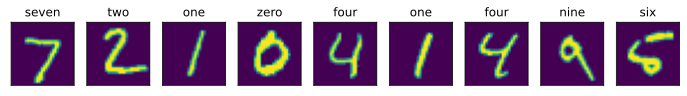

In [12]:
images, labels = iter(test_loader).next()
reshape_images = images.reshape(-1, sequence_length, input_size).to(device)
labels = labels.to(device)

print(images[0].size())

pred_labels = get_mnist_labels(model(reshape_images).argmax(dim=1).cpu().numpy())
titles = pred_labels

show_fashion_mnist(images[0:9], titles[0:9])